# Mach-Zehnder Interferometer

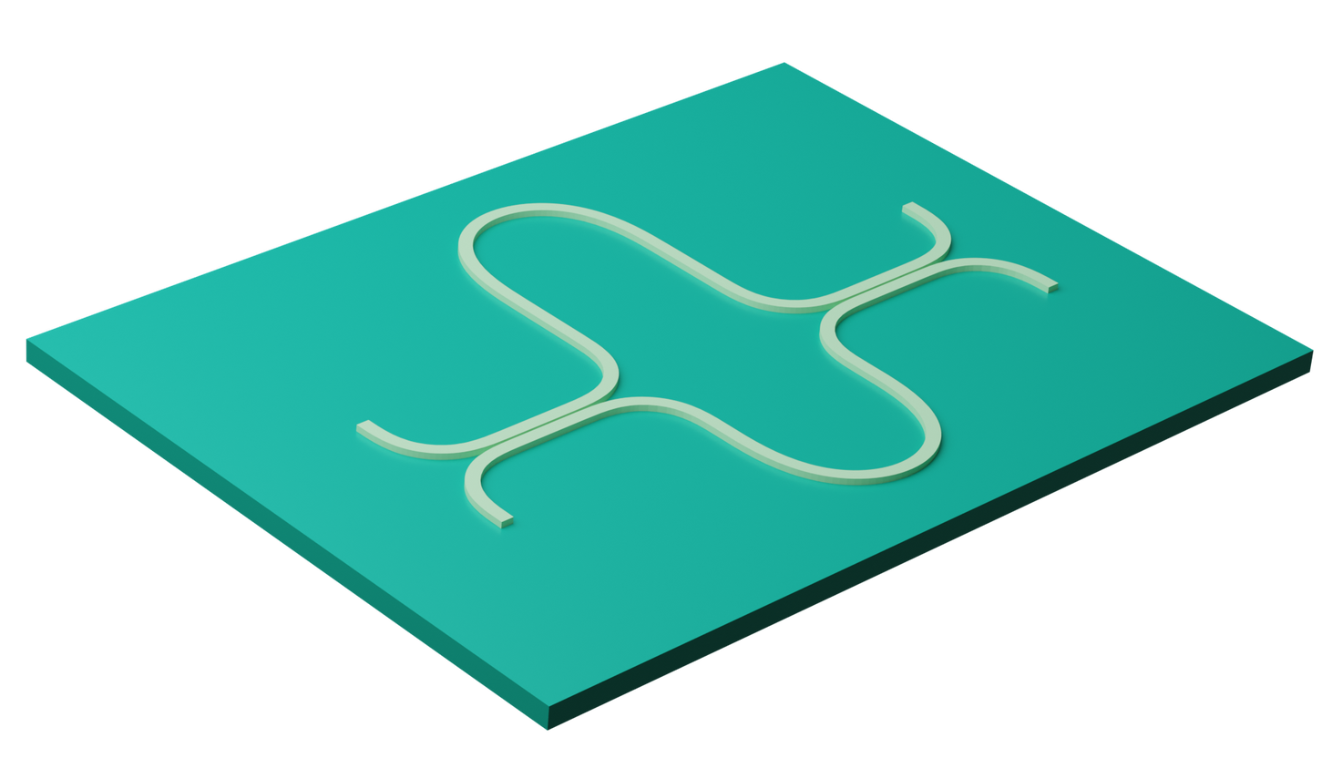

This example shows the design of a simple Mach-Zehnder interferometer (MZI) to demonstrate the use of sub-components to simplify the process.
It also shows the use of (semi-)analytical models to help with system-level design when coupled to circuit and FDTD models.

We will start by setting the default project technology with the [basic_technology](../_autosummary/photonforge.basic_technology.rst) function.
We choose a narrower strip core width so that the waveguide mode is less confined, which facilitates coupling to adjacent waveguides, allowing us to design a more compact directional coupler.

In [1]:
import numpy as np
import photonforge as pf
from matplotlib import pyplot as plt

In [2]:
tech = pf.basic_technology(strip_width=0.45)
pf.config.default_technology = tech

lda = np.linspace(1.5, 1.6, 51)
freqs = pf.C_0 / lda

## Directional Coupler

The MZI will be composed by 2 directional couplers connected by waveguides with different lengths to produce an interference pattern.
Ideally, the directional couplers should provide a power split ratio of 50% to each output.

Before starting, we get the core width from the selected port specification to use as parameters in our geometry.
We ignore the offset in the [path profile](../_autosummary/photonforge.PortSpec.rst) because we know that the strip port has no off-center paths.

In [3]:
port_spec = pf.config.default_technology.ports["Strip"]

core_width, _ = port_spec.path_profile_for("WG_CORE")

The directional coupler is created from the [dual_ring_coupler](../_autosummary/photonforge.parametric.dual_ring_coupler.rst) parametric component.

In [4]:
# Set our default radius
pf.config.default_radius = 3

coupler = pf.parametric.dual_ring_coupler(
    port_spec=port_spec,
    euler_fraction=0.5,
    coupling_distance=core_width + 0.1,
    coupling_length=2.5,
    tidy3d_model_kwargs={
        # These symmetries are not correct for arbitrary ports.
        # They can be used in this case for the fundamental mode.
        "port_symmetries": [
            ("P0", "P1", {"P1": "P0", "P2": "P3", "P3": "P2"}),
            ("P0", "P2", {"P1": "P3", "P2": "P0", "P3": "P1"}),
            ("P0", "P3", {"P1": "P2", "P2": "P1", "P3": "P0"}),
        ],
    },
    name="COUPLER",
)
coupler

We inspect the S parameters of the coupler we have just created using the [plot](../_autosummary/photonforge.plot_s_matrix.rst) utility.
The dimensions of the directional coupler were selected to give 50% power split ratio around the central wavelength by simple parameter sweeping and interpolation.
That process is quite straightforward once we have the component parameterized in a function as we did, so we will not cover it in this example.

Starting...
Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-4U3FZKEJFUYHWPWUSO7S4ZD5OGQPF6HHWV26PICPRVD7HX5RUZ5Q.json.
Progress: 100% 


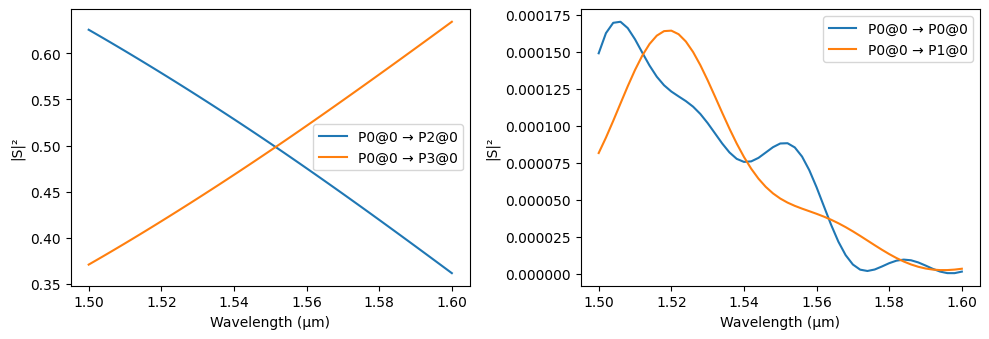

In [5]:
_ = pf.plot_s_matrix(coupler.s_matrix(freqs), input_ports=["P0"])

## Delay Arm

The next component we want to design is a single interferometer arm.
The key MZI parameter controlled by the arms is their length difference.
Because waveguide bends can have a different effective index from straight sections, we will design the arms to have a constant number of bends and include the path difference in straight sections.
We are not too worried about creating a compact design, so we will target simplicity in this example.

The arm will use a parametric [bend](../_autosummary/photonforge.parametric.bend.rst) and [straight](../_autosummary/photonforge.parametric.straight.rst) waveguide sections based on the `extra_length` argument.
[References](../_autosummary/photonforge.Reference.rst) to them will be included in the main component, so they will become sub-components of the delay arm.

Each sub-component reference is positioned by [connecting](../_autosummary/photonforge.Reference.rst#photonforge.Reference.connect) one of its ports to another already-positioned reference.
That way, there's no need to keep track of the exact coordinates of each sub-component in the layout and the connections between waveguide terminations is guaranteed.

Because the arm is built from independent sub-components (straight and bent waveguide sections), we can use a [circuit model](../_autosummary/photonforge.CircuitModel.rst) for computation of its S parameters instead of a full FDTD simulation run.

In [6]:
# We need a 180° bend component for the delay arm
bend = pf.parametric.bend(
    port_spec=port_spec,
    euler_fraction=0.5,
    angle=180,
    name="BEND",
)


def delay_arm(extra_length):
    if extra_length < 0:
        raise NotImplementedError("Argument 'extra_length' cannot be negative.")

    # We will use 2 arms, so let's make sure they have different names
    arm = pf.Component(f"DELAY_ARM_{extra_length}")

    straight = pf.parametric.straight(
        port_spec=port_spec,
        length=extra_length / 2,
        name=f"DELAY_STRAIGHT_{extra_length}",
    )

    ref1 = arm.add_reference(straight)
    ref2 = arm.add_reference(bend).connect("P0", ref1["P1"])
    ref3 = arm.add_reference(straight).connect("P0", ref2["P1"])

    arm.add_port(ref1["P0"])
    arm.add_port(ref3["P1"])
    arm.add_model(pf.CircuitModel(), "Circuit")

    # We don't need to keep 0-length straight sections
    if extra_length == 0:
        arm.remove(ref1, ref3)

    return arm


arm = delay_arm(extra_length=5)
arm

The interdependence between components and sub-components can be inspected through the [references](../_autosummary/photonforge.Component.rst#photonforge.Component.references) of a component, or, more directly, with the [dependencies](../_autosummary/photonforge.Component.rst#photonforge.Component.dependencies) function.
The former will only list the direct references placed in the component, whereas the former will collect all sub-components directly or indirectly used by the parent component.

In [7]:
print(f'References in "{arm.name}"')
for reference in arm.references:
    print(f"- {reference}")

print(f'\nDependencies of "{arm.name}"')
for sub_component in arm.dependencies():
    print(f"- {sub_component}")

References in "DELAY_ARM_5"
- Reference to "DELAY_STRAIGHT_5" at (0, 0)
- Reference to "BEND" at (2.5, 0)
- Reference to "DELAY_STRAIGHT_5" at (2.5, 6)

Dependencies of "DELAY_ARM_5"
- Component "DELAY_STRAIGHT_5"
- Component "BEND"


### Circuit Model Evaluation

We can verify that the circuit model is properly set in the delay arm by getting its [netlist](../_autosummary/photonforge.Component.rst#photonforge.Component.get_netlist).
If any internal or external ports are disconnected, a warning message will let us know so that we can go back and fix the problem.
The information returned in the netlist can be useful to verify that all intended connections are in place for layout verification, but that is not the topic of this example.

In [8]:
arm.get_netlist()

{'instances': [Reference(component="DELAY_STRAIGHT_5", origin=(0, 0), rotation=0, scaling=1, x_reflection=False, repetition=Repetition(columns=1, rows=1, spacing=(0, 0))),
  Reference(component="BEND", origin=(2.5, 0), rotation=0, scaling=1, x_reflection=False, repetition=Repetition(columns=1, rows=1, spacing=(0, 0))),
  Reference(component="DELAY_STRAIGHT_5", origin=(2.5, 6), rotation=180, scaling=1, x_reflection=False, repetition=Repetition(columns=1, rows=1, spacing=(0, 0)))],
 'ports': {(0, 'P0', 1): 'P0', (2, 'P1', 1): 'P1'},
 'connections': [((0, 'P1', 1), (1, 'P0', 1)), ((1, 'P1', 1), (2, 'P0', 1))],
 'virtual connections': []}

We can see the circuit simulation in action by plotting the S parameters of the delay arm.
Note that only 2 mode solver simulations are required for the sub-components, because both the bend and straight sections use [waveguide models](../_autosummary/photonforge.WaveguideModel.rst).
Connecting them through the circuit model requires a few mode solver runs to properly account for the phase and polarization of the mode profiles in rotated and flipped references.

Starting...
Loading cached simulation from .tidy3d/pf_cache/OHD/ms_info-MTY3BEL3D3ZHOQTXDXYXPFVTK72HLXD7WYGBYTLZWITGWC4E4HJQ.json.
Loading cached simulation from .tidy3d/pf_cache/CHK/ms_info-SNDOBTHTSO44QKTL5JSFYAHSFLELF6EDQO5YIQRHP3CZ3AKTTT2A.json.
Loading cached simulation from .tidy3d/pf_cache/RKH/ms_info-6FL7O4ZDHWW6TSPZLDOCASIULQR2IC7KNNY6TVKBCOW4N4WW7GBA.json.
Loading cached simulation from .tidy3d/pf_cache/E5W/ms_info-IK5CI7YMM63WT2ZXAIDEMJAH3WVPKICSV3XKRML34O4VXMLRHJXQ.json.
Loading cached simulation from .tidy3d/pf_cache/RFF/ms_info-FAXK3UUEB23OGWD2T3MSTMD7PCT5WMI224A5NN3T4QLWFOHNTVKQ.json.
Progress: 100% 


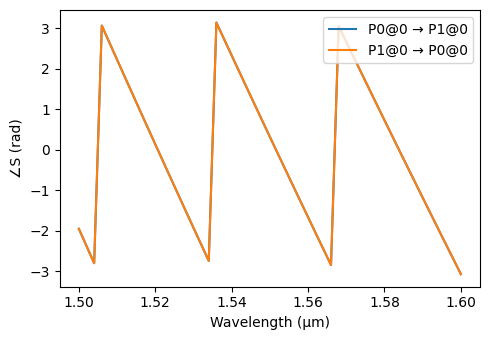

In [9]:
_ = pf.plot_s_matrix(arm.s_matrix(freqs), y="phase")

## Complete MZI

Now we can use the directional coupler and delay arms to create the complete MZI.
Similarly to the arms, the complete MZI can be simulated with a circuit models, because it is composed exclusively by independent sub-components.
That can save on computation time, especially if the S parameters for some or all of the sub-components are already cached, as is the case with the directional coupler that we have simulated before.

In [10]:
def single_mzi(length_difference):
    reference_arm = delay_arm(extra_length=0)
    delay_arm_ = delay_arm(extra_length=abs(length_difference))

    if length_difference == 0:
        upper_arm = reference_arm
        lower_arm = reference_arm
    elif length_difference < 0:
        upper_arm = reference_arm
        lower_arm = delay_arm_
    else:
        upper_arm = delay_arm_
        lower_arm = reference_arm

    mzi = pf.Component("MZI")
    ref1 = mzi.add_reference(coupler)
    ref2 = mzi.add_reference(lower_arm).connect("P0", ref1["P2"])
    ref3 = mzi.add_reference(upper_arm).connect("P1", ref1["P3"])
    ref4 = mzi.add_reference(coupler).connect("P0", ref2["P1"])

    mzi.add_port([ref1["P0"], ref1["P1"], ref4["P2"], ref4["P3"]])
    mzi.add_model(pf.CircuitModel(), "Circuit")

    return mzi


mzi = single_mzi(length_difference=5)
mzi

### Circuit Model Evaluation

Now we compute the S parameters through the circuit model and plot them for inspection.
Note that no FDTD simulations are run, because all required simulations have already been cached.

Starting...
Loading cached simulation from .tidy3d/pf_cache/T72/ms_info-K5JUZ5J62AQNKRNF7TJ3FBDWJ6N65P6UEMGV6G75P7R7P6V427NQ.json.
Loading cached simulation from .tidy3d/pf_cache/2HA/ms_info-MLUDYN323JCBMMBSAWYT65NYWVF33TFUUE3FL34SOH6OYLPF3BSA.json.
Loading cached simulation from .tidy3d/pf_cache/LJI/ms_info-TPQOLCYRUGW7TCQ7BFOV6PKKZ743FH52RK47PY3UURTCJSHQH42Q.json.
Loading cached simulation from .tidy3d/pf_cache/B2R/ms_info-VDXPU4B3QWV6WIQRWUJNMW7BFBXBYG4K52ZIWLKSKPNB5SMSGKBQ.json.
Progress: 100% 


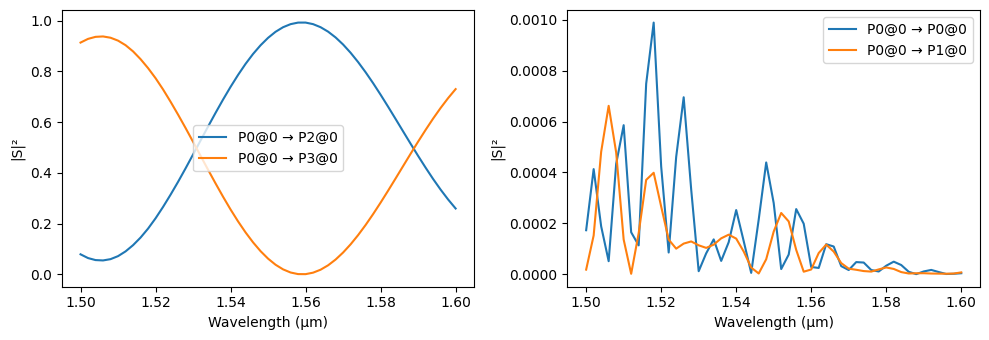

In [11]:
s_circuit = mzi.s_matrix(freqs)

_ = pf.plot_s_matrix(s_circuit, input_ports=["P0"])

### Tidy3D Model Comparison

For the sake of comparison, we can add a Tidy3D model to the MZI and compare the responses.

In [12]:
port_symmetries = [
    ("P0", "P2", {"P1": "P3", "P2": "P0", "P3": "P1"}),
    ("P1", "P3", {"P0": "P2", "P2": "P0", "P3": "P1"}),
]

mzi.add_model(pf.Tidy3DModel(port_symmetries=port_symmetries, verbose=True), "Tidy3D")

print("MZI models:", ", ".join(mzi.models))

MZI models: Tidy3D, Circuit


In [13]:
s_tidy3d = mzi.s_matrix(freqs)

Starting...
Loading cached simulation from .tidy3d/pf_cache/QWB/fdtd_info-DHBUD2UBONFGKAD3CU5XJOKXE45AOJ54QL267WYHIT6IWZLUXKRA.json.
Loading cached simulation from .tidy3d/pf_cache/QWB/fdtd_info-M25CKSTUGNTD5D7BUXMN53W3MXY4LX7IDN73GK5CPDWQCBI5G4OQ.json.
Progress: 100% 


We plot both responses together to see the level of agreement between them.

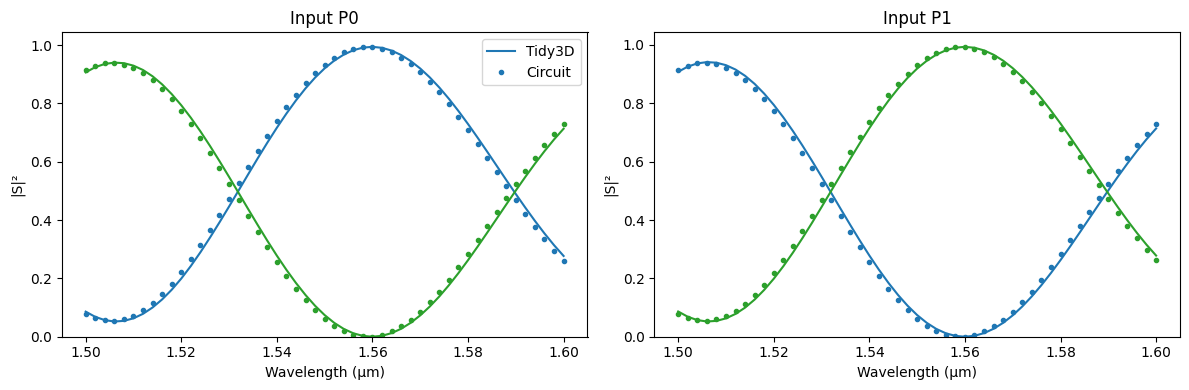

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

for i, in_port in enumerate(["P0", "P1"]):
    for out_port in ["P2", "P3"]:
        key = (f"{in_port}@0", f"{out_port}@0")
        lines = ax[i].plot(lda, np.abs(s_tidy3d[key]) ** 2, "-")
        ax[i].plot(
            lda,
            np.abs(s_circuit[key]) ** 2,
            ".",
            mfc=lines[0].get_color(),
            mec=lines[0].get_color(),
        )
    ax[i].set_xlabel("Wavelength (μm)")
    ax[i].set_ylabel("|S|²")
    ax[i].set_ylim(0, None)
    ax[i].set_title(f"Input {in_port}")

_ = ax[0].legend(["Tidy3D", "Circuit"])

## Semi-Analytical Design Exploration

We want to explore the effect of the path difference in our MZI period.
The straightforward option is to try a few values of `length_difference` and check the S parameters from the circuit model, which will require only the FDTD simulation of the new straight section, which is quite fast in Tidy3D.

However, there is an even faster approach.
Instead of using a Tidy3D model for the section we are varying, we can use a semi-analytical [waveguide model](../_autosummary/photonforge.WaveguideModel.rst).
It uses the effective index of the port modes to model the propagation in a straight waveguide.
The effective index can be preset by us, or automatically calculated with Tidy3D's mode solver.

The straight section already includes a waveguide model (inactive, by default), and it uses the physical section length to compute the propagation model.
What we can do instead, is set the model length to any desired value without changing the layout.
The model will no longer correspond to the physical layout, but it will give us the S parameters for an equivalent MZI with the specified path length difference for fast exploration.

We start by selecting the straight section we want to modify from the list of sub-components of the MZI:

In [15]:
print("MZI sub-components:")

sub_components = mzi.dependencies()
for c in sub_components:
    print(f"- {c.name}")

MZI sub-components:
- COUPLER
- DELAY_ARM_0
- BEND
- DELAY_ARM_5
- DELAY_STRAIGHT_5


We're interested in the "DELAY_STRAIGHT_5", which is the straight section of the 5 μm delay arm (the actual path length is half of that, because the extra straight section is used twice).
We select the desired component and change its active model to the waveguide model.

Not that the model has both `n_complex` and `length` set to `None`, which means they are automatically computed based on the component's ports.
We will override `lenght` to the virtual value we want to test.

In [16]:
for c in sub_components:
    if c.name == "DELAY_STRAIGHT_5":
        straight = c
        break

straight.activate_model("Waveguide")
model = straight.active_model
model

WaveguideModel(n_complex=None, length=None, mesh_refinement=None, verbose=True)

We can update the model in place with [Model.update](../_autosummary/photonforge.Model.rst#photonforge.Model.update) by passing it the new keyword arguments we want the model to use.

For example, if we set the path length difference to 0, we expect full transmission from P0 to P3, except from losses and reflections, as we see next.

Starting...
Progress: 100% 


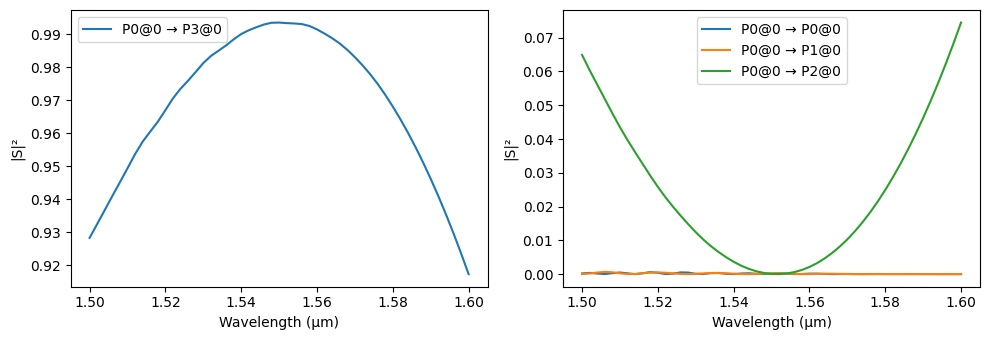

In [17]:
model.update(length=0)

mzi.activate_model("Circuit")
_ = pf.plot_s_matrix(mzi.s_matrix(freqs), input_ports=["P0"])

By comparing this semi-analytical model with the full FDTD run, we see again a very good match.

Starting...
Progress: 100% 


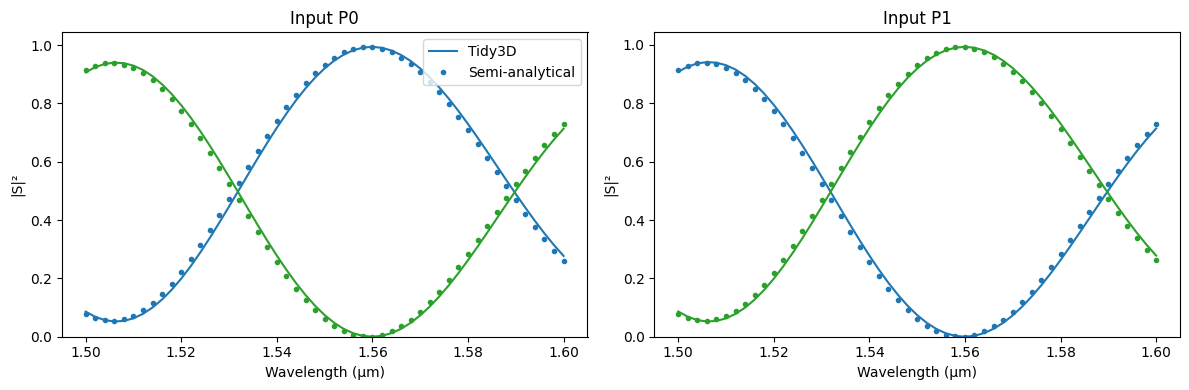

In [18]:
model.update(length=5.0 / 2)
s_analytical = mzi.s_matrix(freqs)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

for i, in_port in enumerate(["P0", "P1"]):
    for out_port in ["P2", "P3"]:
        key = (f"{in_port}@0", f"{out_port}@0")
        lines = ax[i].plot(lda, np.abs(s_tidy3d[key]) ** 2, "-")
        ax[i].plot(
            lda,
            np.abs(s_analytical[key]) ** 2,
            ".",
            mfc=lines[0].get_color(),
            mec=lines[0].get_color(),
        )
    ax[i].set_xlabel("Wavelength (μm)")
    ax[i].set_ylabel("|S|²")
    ax[i].set_ylim(0, None)
    ax[i].set_title(f"Input {in_port}")

_ = ax[0].legend(["Tidy3D", "Semi-analytical"])

Because the mode solver run required to calculate the effective index for the waveguide mode is cached, we can inspect the effects of the path difference extremely fast.
In Jupyter, we can use an interactive control to see those change almost live (the widget is only visible in a live notebook session):

In [19]:
from ipywidgets import FloatSlider, interactive


def update_and_plot(Δl):
    model.update(length=Δl / 2)
    pf.plot_s_matrix(mzi.s_matrix(freqs), input_ports=["P0"])


interactive(update_and_plot, Δl=FloatSlider(min=0, max=20, continuous_update=False))

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Δl', max=20.0), Output()), …

Once we've finished our exploration we can go back to the original model with the desired parameters so that we can, for example, [export a GDSII](../_autosummary/photonforge.Component.rst#photonforge.Component.write_gds) layout of the final device.
We can also [store a PhotonForge project file](../_autosummary/photonforge.write_phf.rst) that can be imported in the [web UI](https://tidy3d.simulation.cloud/) or shared.

In [20]:
final_mzi = single_mzi(length_difference=10)

# Export GDSII layout
final_mzi.write_gds()

# Save PhotonForge project file
pf.write_phf("MZI.phf", final_mzi)

## Monte Carlo and Corner Case Analyses

Running Monte Carlo or corner case analyses can be done by simply defining the [random variables](../_autosummary/photonforge.monte_carlo.RandomVariable.rst) we want to include and selecting the number of samples to compute using the [s_matrix](../_autosummary/photonforge.monte_carlo.s_matrix.rst) function in the `monte_carlo` sub module.

We can test, for example, the corner cases of our final device with respect to variations in the core layer thickness and sidewall angle, which are 2 pre-defined variables for the basic technology.

In [21]:
tech.random_variables

[RandomVariable('core_thickness', **{'value': 0.22, 'stdev': 0.002}),
 RandomVariable('slab_thickness', **{'value': 0.07, 'stdev': 0.005}),
 RandomVariable('clad_thickness', **{'value': 1.0, 'stdev': 0.05}),
 RandomVariable('box_thickness', **{'value': 1.0, 'stdev': 0.05}),
 RandomVariable('mask_dilation', **{'value': 0.0, 'stdev': 0.005}),
 RandomVariable('sidewall_angle', **{'value': 0.0, 'stdev': 2.0})]

In [22]:
variables, results = pf.monte_carlo.s_matrix(
    final_mzi,
    freqs,
    ("core_thickness", tech),
    ("sidewall_angle", tech),
    corner_samples=4,
    random_seed=0,
)

Sample 1 of 4...Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-ADX2YRLHQTZWWQX6LGO3Q7N65TBNX4ZCFQTEVWCEXFRORSOXXZRQ.json.
Loading cached simulation from .tidy3d/pf_cache/ZCY/ms_info-NXENUC2YWEUPESDW3TEFGRMMNI4K5BIJM3RMLRGIIA7PB5IBF2YA.json.
Loading cached simulation from .tidy3d/pf_cache/QBF/ms_info-TMSNEIRBGNEAUM5LBVKF4UR4QWVKZWFSCBIKIYWSTTXXCTY3M33Q.json.
Loading cached simulation from .tidy3d/pf_cache/XNH/ms_info-P2S5XOWLB4TMIENIW5DKPNUVCIS4EBL6WPZ3WZP2ODJYH5IRN4UQ.json.
Loading cached simulation from .tidy3d/pf_cache/LXO/ms_info-JHLICOOHPB4IJRDA3QWYLII6GQQDPKJXJ4M2EFBSWTU2XS23YTCQ.json.
Loading cached simulation from .tidy3d/pf_cache/HXO/ms_info-YND7UN7F5VOC3BFRJCRBN7TTVOMSUN2XIS7JPS5OYPEFHZWJ25FA.json.


Loading cached simulation from .tidy3d/pf_cache/GSW/ms_info-HPHLI5OVLAG3APLTPJKRWZJZJ6ZPLCI4SWJMMGX5RBNPEQ2K7FPQ.json.
Loading cached simulation from .tidy3d/pf_cache/NT5/ms_info-XBHKE5FHQXBYIKRQQPQ6SYICPWRCFUZX2MSDTXJP3PVRY223U4ZA.json.
Loading cached simulation from .tidy3d/pf_cache/YQU/ms_info-FJXZHTLAEDU2NXD6NMNLDI3VRKKOURQROFKXUYIHHLZZLW3WZJQA.json.
Loading cached simulation from .tidy3d/pf_cache/H7C/ms_info-3MSDYWCCCJQ3THAO2WE5VAGF6NT2YIJCLWRRUXOVGA2NJWTS54LQ.json.


Sample 2 of 4...Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-FL4KXFWK2SPXE5JILNFHHRRD6KEQK7MKTFFLY72OMGE6OI2QUPTQ.json.
Loading cached simulation from .tidy3d/pf_cache/IJK/ms_info-NMRWIIAGGMGUKIDWMOIROCBGJRYAZE3LFNZNGFNEETR3FDGVPCKQ.json.
Loading cached simulation from .tidy3d/pf_cache/D7V/ms_info-VHZ2M5K72RLK7HWU6EUTXYTQP6V62KKDS6WASBTJNFGZ3RFRQBXQ.json.
Loading cached simulation from .tidy3d/pf_cache/5RD/ms_info-OQ7U3LN7PXEXBYZWPVRXFI4CONBQPAUCKXXYYF4QNKPL3B4M7GUA.json.
Loading cached simulation from .tidy3d/pf_cache/26D/ms_info-QTJSZ6H6KHR3PAEZNWFJ7PLK7HYUCK44P3PO5L7MWA274A3VQHVA.json.
Loading cached simulation from .tidy3d/pf_cache/AJ4/ms_info-BJDUW6I736VZS5PT7FWUAMEAOZXUH6PS5UCQYJO255P2XL5WZWOA.json.


Loading cached simulation from .tidy3d/pf_cache/QV2/ms_info-FL5P4S7P642BPHBJ26CFIHTWPE5XREDQ6SWMBQUJPELV65ODS3ZQ.json.
Loading cached simulation from .tidy3d/pf_cache/KGJ/ms_info-CVOBMYUBI6OXKBU7ZMNNUG4WXUULXXGMW7DOQMYTHNPJZLH23MZQ.json.
Loading cached simulation from .tidy3d/pf_cache/WDT/ms_info-X32ZVYGBAYLZMDAPOQELVM2UQSDAP7PEFYJISJML6AMFQWYH3YMQ.json.
Loading cached simulation from .tidy3d/pf_cache/BAN/ms_info-IL7OM3GHCRXVJA3PDSKLN3VDJACBQHK4NVGCLHRPQZE6W7SIJWUQ.json.


Sample 3 of 4...Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-OJOQKU47GZFXD7K2GF2BVQ3IZJZX7JBNSNSYAY4LR55WHLIB2SJA.json.
Loading cached simulation from .tidy3d/pf_cache/SQX/ms_info-BGTUW5HO7IHYL5WITXOAGK7USK7MNKFTP52DCE546Y74RZQKHQWA.json.
Loading cached simulation from .tidy3d/pf_cache/J7K/ms_info-QHLMWT2DUMO2Q7IAVWOGRLPEXHK4BHHNL6FEFVWYHX7NXTJFRODA.json.
Loading cached simulation from .tidy3d/pf_cache/6WH/ms_info-K5H5J7AAFKFSJVILAJICOWAR5S7W4CBYTI6RLKVYORAPJFYG726A.json.
Loading cached simulation from .tidy3d/pf_cache/MWU/ms_info-7RT3VXP2KPQSSO5R5CK2KNOJ27JQKAANDQJNLZJ6OKRMIARMVUIQ.json.
Loading cached simulation from .tidy3d/pf_cache/6EZ/ms_info-7PFGC4URCAZZFK6GHJY2HRI7VJ7MZTDDBIA2CYLL3S6NLKZSEPCA.json.


Loading cached simulation from .tidy3d/pf_cache/TZW/ms_info-UBH55UMVBEOZGYJPELNHSBSZQMOPCJFR5EACPYUL2KAPUF53FCDQ.json.
Loading cached simulation from .tidy3d/pf_cache/2LR/ms_info-LE5SWXG4AJP3JIIL2QWC7IC3WWHULIF2DRXHZEIBAKGXDQ5NDEUQ.json.
Loading cached simulation from .tidy3d/pf_cache/66L/ms_info-3K7O65IHYBAVN3UTBI3JXMALGA5JTNMNTU3XDPZIKE3JOAS64E2A.json.
Loading cached simulation from .tidy3d/pf_cache/6AY/ms_info-J62HLYASR6M4HCQ7MZLVM6NBWZHZCVRKPGKGGYMULWRJ4SR4POHQ.json.


Sample 4 of 4...Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-ITLFUQIUD562SGBXEI5YR2XLEETAOXYLH3B4DRETWPF6VXKTKGYQ.json.
Loading cached simulation from .tidy3d/pf_cache/AD2/ms_info-NUXAXZJMTSJZVJC6B2HZ6T3PM7ITHOBJPBZUOMYJKJELKAQARVHQ.json.
Loading cached simulation from .tidy3d/pf_cache/LIF/ms_info-VJPW35T5A5LUQTNYALMZZ3ECYSMR4PQCSYLDUMPYSMTBDHKZZQ7Q.json.
Loading cached simulation from .tidy3d/pf_cache/AYT/ms_info-FTCXXB6L4VMTFDV3SFLJX3LTQTE3GE56NMA6PW6XKG5QMFDKHAJA.json.
Loading cached simulation from .tidy3d/pf_cache/IM3/ms_info-EIGDL3GFMHDWY3XOXYBEJCI66REPEVWILHXUD4FRBJLUNS36ZQWQ.json.
Loading cached simulation from .tidy3d/pf_cache/XBT/ms_info-LHK2HVCUNGD3F6NIX3ERCH44G5PZXSD4WE2EDQDTNVQI4O536O5A.json.


Loading cached simulation from .tidy3d/pf_cache/G3R/ms_info-EY5EZ5VZJA3HKTFLD3GJOHUJO4D42TWRDULSGOG7RUCHQPDDZXCQ.json.
Loading cached simulation from .tidy3d/pf_cache/FKR/ms_info-N2TB7LEDKGES6NYFNMAOZPAZGUQ2IP2DM6EMOURW26Y7DCVT4ZGQ.json.
Loading cached simulation from .tidy3d/pf_cache/LD5/ms_info-TEBPEHIF5KF32RYJ43TSZUXVDLLO7NPFMMS2LFQKMUHZ5VJY2QEQ.json.
Loading cached simulation from .tidy3d/pf_cache/25N/ms_info-YMDY36XUF2X7V2XSG4L5Q5JZ2QH23BPLJWSWONVIKMBPSMXI7LQA.json.


 done!


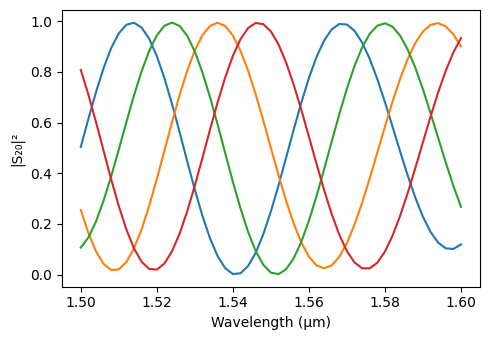

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), tight_layout=True)

for *_, s in results:
    ax.plot(lda, np.abs(s[("P0@0", "P2@0")]) ** 2)

ax.set_xlabel("Wavelength (μm)")
_ = ax.set_ylabel("|S₂₀|²")